In [373]:
%matplotlib inline

import os.path
import random
import re
import json

import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.model_selection import cross_val_score

from atntools import util

In [374]:
initial_uniform_set = 0
first_multi_region_set = 13
second_multi_region_set = 14

set_number = first_multi_region_set

training_batch = 0
training_batch_2 = 2
training_batch_3 = 3
test_batch = 1

set_dir = util.find_set_dir(set_number)
food_web_id = re.match(r'.*?((\d+-)+\d+).*', set_dir).group(1)
print(set_dir)
print(food_web_id)

/Users/ben/SFSU/thesis/data/5-species/2-8-9-26-41/set-13
2-8-9-26-41


In [393]:
def get_batch_summary(set_dir, batch_num):
    summary_file = os.path.join(util.find_batch_dir(set_dir, batch_num), 'summary.csv')
    return pd.read_csv(summary_file)

training_df = get_batch_summary(set_dir, training_batch)

# Add more training data
training_df = training_df.append(get_batch_summary(set_dir, training_batch_2))
#training_df = training_df.append(get_batch_summary(set_dir, training_batch_3))

training_df.head()

,batch_number,set_number,sim_number,K2,X26,X41,X8,X9,initialBiomass2,initialBiomass26,...,perUnitBiomass8,perUnitBiomass9,extinction_2,extinction_26,extinction_41,extinction_8,extinction_9,extinction_count,stop_event,timesteps_simulated
0,0,13,0,6159.760,0.185261,0.161514,0.483434,0.602287,4511.40,4818.710,...,1.0,1.0,-1,1370,2280,-1,-1,2,OSCILLATING_STEADY_STATE,8406
1,0,13,1,9843.530,0.511866,0.529141,0.480717,0.045213,4064.85,2039.620,...,1.0,1.0,-1,1030,741,-1,-1,2,OSCILLATING_STEADY_STATE,16127
2,0,13,2,859.248,0.808830,0.677815,0.154646,0.801382,3984.25,3747.980,...,1.0,1.0,-1,429,544,-1,-1,2,OSCILLATING_STEADY_STATE,1167
3,0,13,3,6650.920,0.656525,0.066649,0.477812,0.996610,4800.44,349.439,...,1.0,1.0,-1,442,5416,-1,-1,2,OSCILLATING_STEADY_STATE,8448
4,0,13,4,545.753,0.695684,0.894182,0.194586,0.536934,3219.54,3620.090,...,1.0,1.0,-1,481,410,-1,-1,2,CONSTANT_BIOMASS_WITH_CONSUMERS,2104


In [394]:
# Look at distribution of stop_event

training_df['stop_event'].value_counts()

CONSTANT_BIOMASS_WITH_CONSUMERS    950
OSCILLATING_STEADY_STATE           945
NONE                               102
UNKNOWN_EVENT                        3
Name: stop_event, dtype: int64

In [395]:
# Remove inconclusive simulations

training_df_filtered = training_df[
    (training_df['stop_event'] != 'NONE') &
    (training_df['stop_event'] != 'UNKNOWN_EVENT')].copy()
training_df_filtered['stop_event'].value_counts()

CONSTANT_BIOMASS_WITH_CONSUMERS    950
OSCILLATING_STEADY_STATE           945
Name: stop_event, dtype: int64

In [396]:
# Look at distribution of extinction_count among simulations with conclusive stop_events

ec = training_df_filtered['extinction_count']

ec.value_counts(normalize=True).sort_index()

0    0.006860
1    0.148813
2    0.806332
3    0.037995
Name: extinction_count, dtype: float64

In [397]:
median_extinction_count = ec.median()
median_extinction_count

2.0

In [398]:
# Assign balanced classes based on median extinction count

def class_label(x):
    return 1 if x < median_extinction_count else 0

training_df_filtered['class_label'] = ec.map(class_label)
pd.crosstab(training_df_filtered['extinction_count'], training_df_filtered['class_label'])

class_label,0,1
extinction_count,,
0,0,13
1,0,282
2,1528,0
3,72,0


In [399]:
training_df_filtered['class_label'].value_counts()

0    1600
1     295
Name: class_label, dtype: int64

In [400]:
# Make above into a function

def label_dataset(df, median_extinction_count=None):
    
    df = df[
        (df['stop_event'] != 'NONE') &
        (df['stop_event'] != 'UNKNOWN_EVENT')].copy()
    
    if median_extinction_count is None:
        median_extinction_count = df['extinction_count'].median()
    
    df['class_label'] = df['extinction_count'].map(lambda x: 1 if x < median_extinction_count else 0)
    
    return df, median_extinction_count

training_df_filtered, median_extinction_count = label_dataset(training_df)

training_df_filtered['class_label'].value_counts()

0    1600
1     295
Name: class_label, dtype: int64

In [401]:
# Balance training set by undersampling
#df0 = training_df_filtered[training_df_filtered['class_label'] == 0].sample(n=145)
#df1 = training_df_filtered[training_df_filtered['class_label'] == 1]
#training_df_filtered = df0.append(df1)

In [402]:
# Prepare X_train

X_cols = []
for col in training_df.columns:
    if col[0] in ('K', 'X'):
        X_cols.append(col)
    elif col.startswith('initialBiomass'):
        X_cols.append(col)

X_train = training_df_filtered[X_cols]
X_train.head()

,K2,X26,X41,X8,X9,initialBiomass2,initialBiomass26,initialBiomass41,initialBiomass8,initialBiomass9
0,6159.760,0.185261,0.161514,0.483434,0.602287,4511.40,4818.710,2446.98,4509.550,3685.67
1,9843.530,0.511866,0.529141,0.480717,0.045213,4064.85,2039.620,3072.78,3268.810,2819.37
2,859.248,0.808830,0.677815,0.154646,0.801382,3984.25,3747.980,1712.94,156.454,1308.25
3,6650.920,0.656525,0.066649,0.477812,0.996610,4800.44,349.439,3003.60,4457.340,2582.21
4,545.753,0.695684,0.894182,0.194586,0.536934,3219.54,3620.090,3685.99,3228.640,1633.11


In [403]:
# Prepare y_train

y_train = training_df_filtered['class_label']
y_train.head()

0    0
1    0
2    0
3    0
4    0
Name: class_label, dtype: int64

In [407]:
# Create the model and do cross-validation on the training data
clf = DecisionTreeClassifier(
    min_samples_leaf=0.01,
    class_weight='balanced',
    #min_weight_fraction_leaf=0.01
)
cross_val_score(clf, X_train, y_train, cv=10)

array([ 0.87894737,  0.92105263,  0.89473684,  0.9       ,  0.90526316,
        0.91005291,  0.88359788,  0.92592593,  0.8994709 ,  0.87301587])

In [408]:
# Fit the model on all the training data
clf = clf.fit(X_train, y_train)

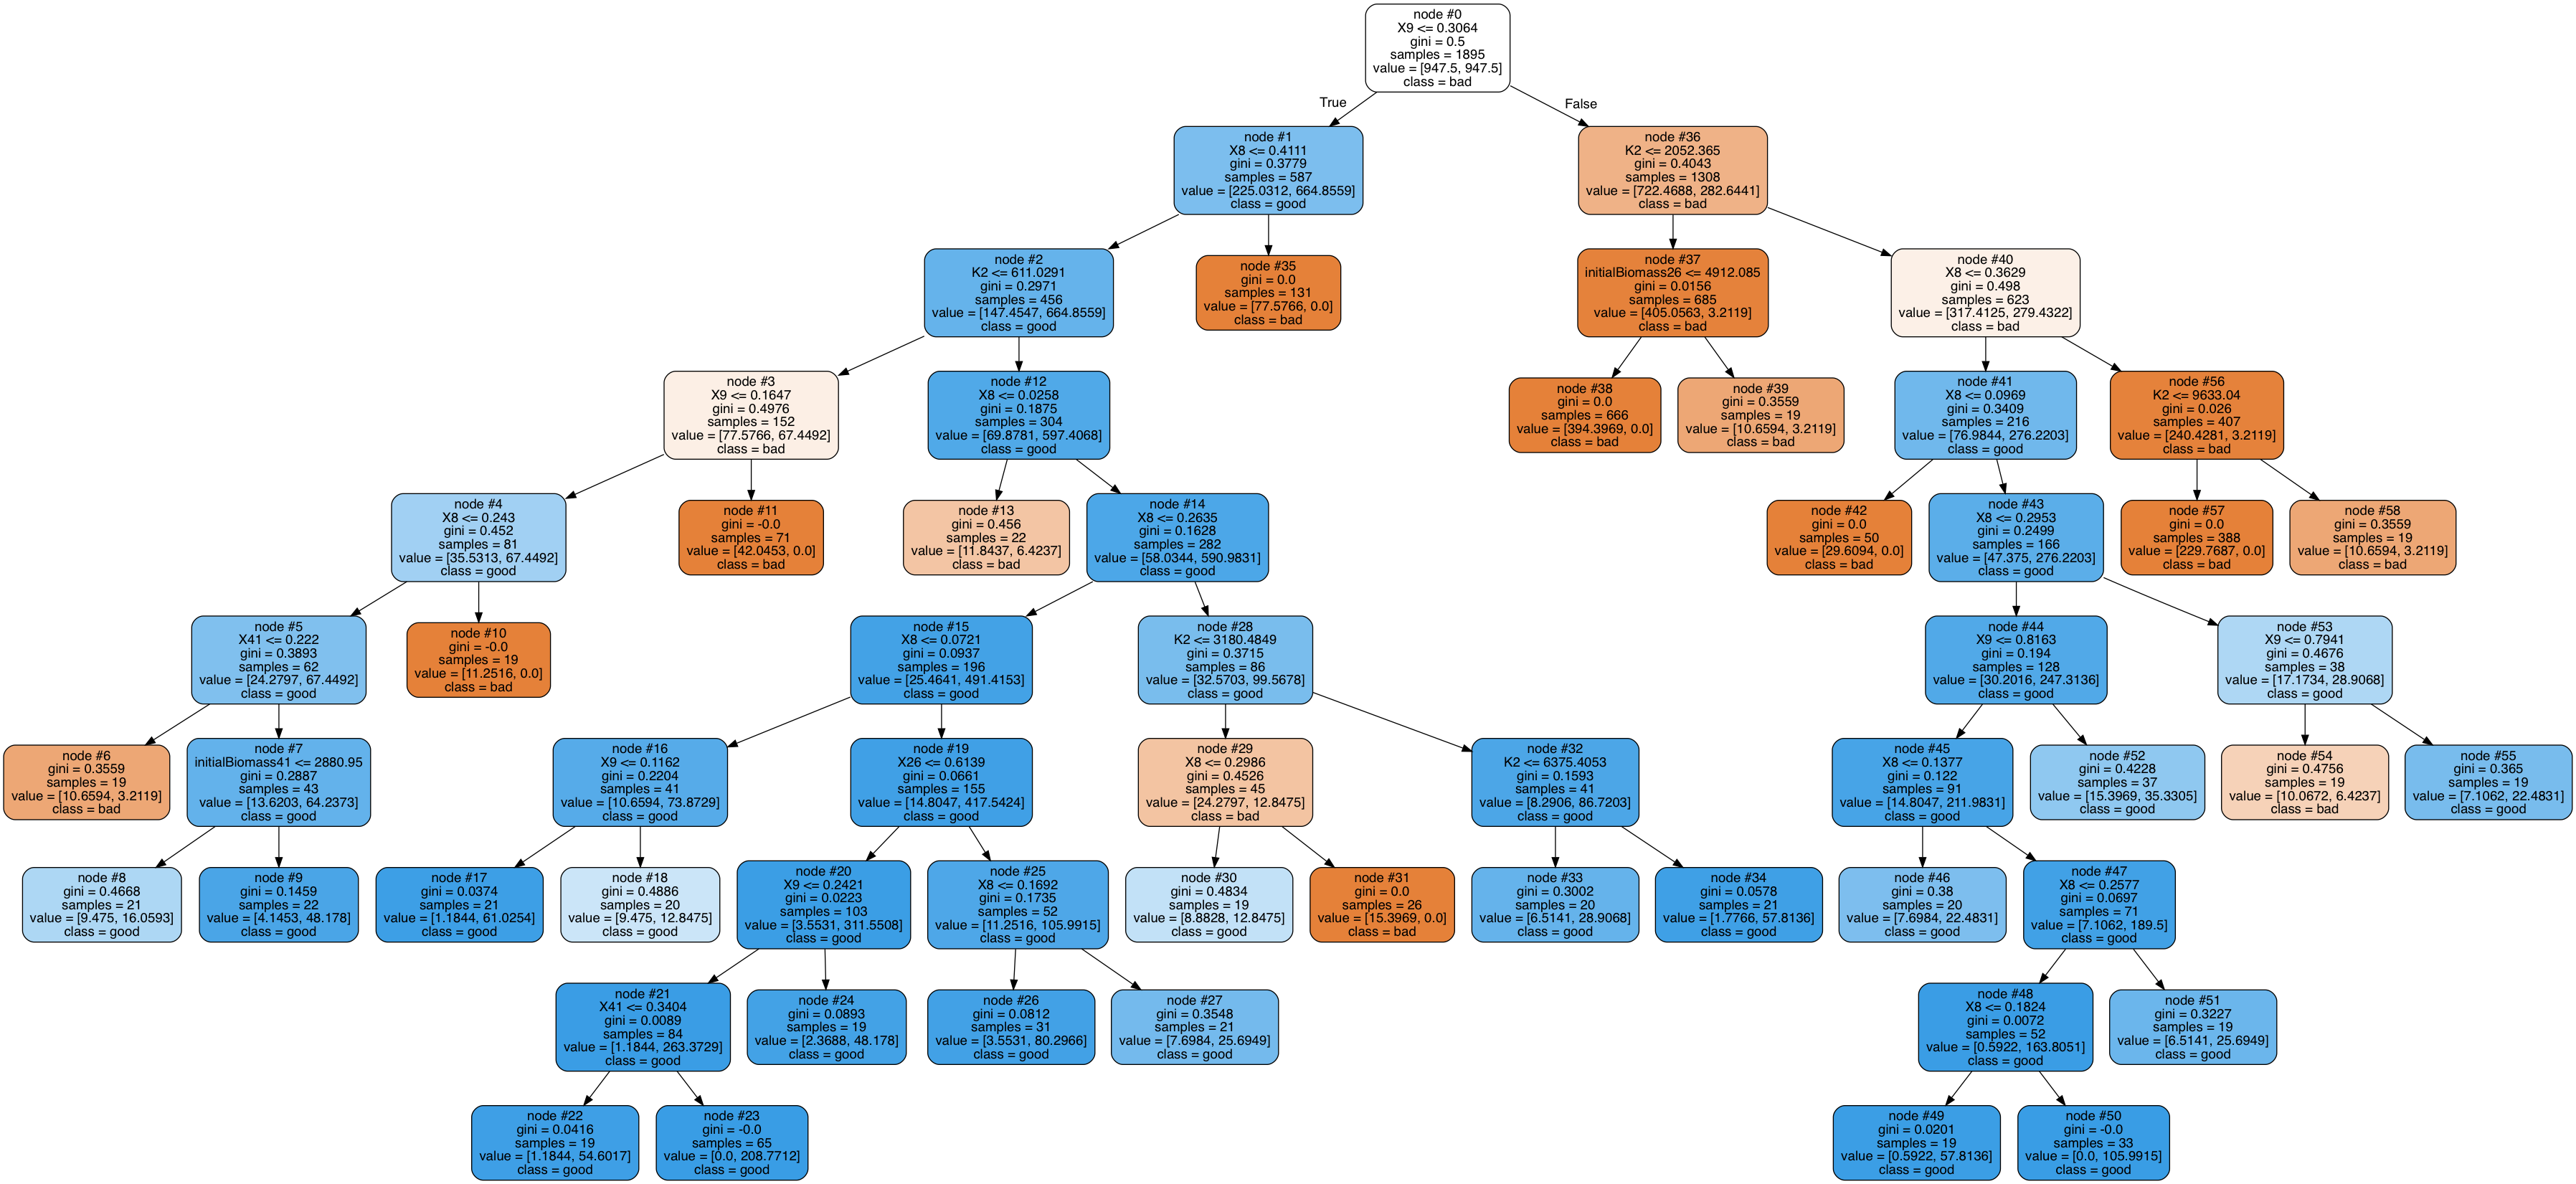

In [409]:
# Visualize the decision tree

from sklearn import tree
import pydotplus 
from IPython.display import Image

def visualize_tree(classifier, feature_names):
    dot_data = tree.export_graphviz(
        classifier, out_file=None,
        feature_names=feature_names,
        class_names=['bad', 'good'],
        filled=True, rounded=True, node_ids=True
    )
    graph = pydotplus.graph_from_dot_data(dot_data)  
    return Image(graph.create_png())
    
visualize_tree(clf, X_cols)

In [410]:
# Every classifier has a "score" method
clf.score(X_train, y_train)

0.9129287598944591

In [411]:
# Evaluation on training data

y_predict = clf.predict(X_train)

print("Feature importances:")
for importance, feature in sorted(zip(clf.feature_importances_, X_cols), reverse=True):
    print("{:2.2f}  {}".format(importance, feature))

print(classification_report(y_train, y_predict))
print(confusion_matrix(y_train, y_predict))
f1_score(y_train, y_predict, average=None)

Feature importances:
0.46  X8
0.31  X9
0.21  K2
0.01  X41
0.00  initialBiomass41
0.00  initialBiomass26
0.00  X26
0.00  initialBiomass9
0.00  initialBiomass8
0.00  initialBiomass2
             precision    recall  f1-score   support

          0       1.00      0.90      0.95      1600
          1       0.65      0.98      0.78       295

avg / total       0.94      0.91      0.92      1895

[[1442  158]
 [   7  288]]


array([ 0.9458839 ,  0.77732794])

# Evaluation on test set

In [412]:
test_df = get_batch_summary(set_dir, test_batch)

test_df, _ = label_dataset(test_df, median_extinction_count)

test_df['class_label'].value_counts()

0    820
1    125
Name: class_label, dtype: int64

In [413]:
X_test = test_df[X_cols]
y_test = test_df['class_label']
y_predict = clf.predict(X_test)
print(classification_report(y_test, y_predict))
print(confusion_matrix(y_test, y_predict))

f1_score(y_test, y_predict, average=None)

             precision    recall  f1-score   support

          0       0.98      0.90      0.94       820
          1       0.58      0.90      0.70       125

avg / total       0.93      0.90      0.91       945

[[737  83]
 [ 12 113]]


array([ 0.93945188,  0.70404984])

# Synthesizing new data in the "1" class

In [21]:
#help(clf.tree_)

In [22]:
from sklearn.tree._tree import TREE_LEAF

In [23]:
def get_leaves(tree):
    """ Return the node IDs of the leaves in the given sklearn Tree """
    return [i for i in range(tree.node_count) if tree.children_left[i] == TREE_LEAF]

#get_leaves(clf.tree_)

In [24]:
#for leaf in get_leaves(clf.tree_):
#    print("leaf = {}, value = {}, shape = {}".format(leaf, clf.tree_.value[leaf], clf.tree_.value[leaf].shape))

In [25]:
def dfs(tree, node_id=0):
    print(node_id)
    if tree.children_left[node_id] == TREE_LEAF:
        return
    dfs(tree, tree.children_left[node_id])
    dfs(tree, tree.children_right[node_id])
    
#dfs(clf.tree_)

In [26]:
from copy import deepcopy

# NOT USED

def get_leaf_regions(tree, node_id=0, subtree_region={}):
    """
    Calculate the feature bounds of each leaf defined by the path from the root to the leaf.
    
    Parameters
    ----------
    tree : sklearn.tree._tree.Tree
        The underlying Tree object of a trained classifier
    node_id : int
        The node ID of the root node of the subtree to traverse
    subtree_region : dict
        A dict describing the feature bounds to which this subtree is constrained.
        Key: feature_id
        Value: [lower_bound, upper_bound] (Either value may be None)
        
    Returns
    -------
    dict
        A dict of dicts describing the feature bounds to which each leaf of this subtree is constrained.
        Key: node_id of leaf
        Value: dict in the same format as subtree_region
    """
    
    if tree.children_left[node_id] == TREE_LEAF:
        return {node_id: deepcopy(subtree_region)}
    
    feature_id = tree.feature[node_id]
    feature_threshold = tree.threshold[node_id]
    
    left_subtree_region = deepcopy(subtree_region)
    if feature_id not in left_subtree_region:
        left_subtree_region[feature_id] = [None, feature_threshold]
    elif left_subtree_region[feature_id][1] is None:
        left_subtree_region[feature_id][1] = feature_threshold
    else:
        left_subtree_region[feature_id][1] = min(left_subtree_region[feature_id][1], feature_threshold)
    
    right_subtree_region = deepcopy(subtree_region)
    if feature_id not in right_subtree_region:
        right_subtree_region[feature_id] = [feature_threshold, None]
    elif right_subtree_region[feature_id][0] is None:
        right_subtree_region[feature_id][0] = feature_threshold
    else:
        right_subtree_region[feature_id][0] = max(left_subtree_region[feature_id][0], feature_threshold)
    
    leaf_regions = get_leaf_regions(tree, tree.children_left[node_id], left_subtree_region)
    leaf_regions.update(get_leaf_regions(tree, tree.children_right[node_id], right_subtree_region))
    
    return leaf_regions
    
#leaf_regions = get_leaf_regions(clf.tree_)
#leaf_regions

In [27]:
def get_good_leaves(tree):
    return [
        i for i in range(tree.node_count)
        if tree.children_left[i] == TREE_LEAF
        and tree.value[i, 0, 1] > tree.value[i, 0, 0]
    ]
get_good_leaves(clf.tree_)

[6, 11, 12, 13, 17, 18, 36, 37, 38, 43, 46, 50]

- function to generate synthetic data points from good leaf regions
- arguments:
    - regions
    - default upper and lower bounds
        - actually, modify get_leaf_regions to take default upper/lower bounds; should simplify its code
        - set default bounds to either:
            - metaparameter bounds (seems better)
            - observed bounds in training data
- replace get_leaf_regions with get_node_bounds
    - populates a 3D array: [node_id, feature_id, 0/1]  shape = (n_nodes, n_features, 2)
    - calculate_node_bounds(node_id, node_bounds_array)
    - first call: node_id is 0, node_bounds_array first row is initialized to metaparameter bounds
    - each call: calculate bounds of left child and right child, then recursively call on left child and right child to have them calculate the bounds for their children
    - data has to be copied and computed for every node anyway, not much downside to computing bounds for all nodes

# Calculating region bounds

In [28]:
def parse_feature_name(feature_name):
    """ Convert a feature name such as "X8" into a node-id, param-name pair such as (8, 'X') """
    match = re.match(r'^([a-zA-Z]+)(\d+)$', feature_name)
    if match is None:
        raise RuntimeError("Invalid feature name {}".format(feature_name))
    param = match.group(1)
    node_id = int(match.group(2))
    return node_id, param

print(parse_feature_name('X8'))
print(parse_feature_name('initialBiomass14'))

(8, 'X')
(14, 'initialBiomass')


## Getting root bounds

In [29]:
def get_metaparameters_for_set(set_identifier):
    """ Parse the metaparameters.json file for the given set (directory or set number)
    and return the parsed dict.
    """
    if isinstance(set_identifier, int):
        set_dir = util.find_set_dir(set_identifier)
    else:
        set_dir = set_identifier

    with open(os.path.join(set_dir, 'metaparameters.json'), 'r') as f:
        metaparameters = json.load(f)
    
    return metaparameters

metaparameters = get_metaparameters_for_set(set_dir)
metaparameters

{'args': {'count': 1000,
  'regions': [{'bounds': {'2': {'K': [347.3869934082031, 933.281982421875],
      'initialBiomass': [100.0, 5000.0]},
     '26': {'X': [0.0, 1.0], 'initialBiomass': [100.0, 5000.0]},
     '41': {'X': [0.0, 1.0], 'initialBiomass': [100.0, 5000.0]},
     '8': {'X': [0.0, 0.12120950222015381], 'initialBiomass': [100.0, 5000.0]},
     '9': {'X': [0.0, 1.0], 'initialBiomass': [100.0, 5000.0]}},
    'weight': 1},
   {'bounds': {'2': {'K': [347.3869934082031, 933.281982421875],
      'initialBiomass': [100.0, 5000.0]},
     '26': {'X': [0.0, 1.0], 'initialBiomass': [100.0, 5000.0]},
     '41': {'X': [0.0, 1.0], 'initialBiomass': [100.0, 5000.0]},
     '8': {'X': [0.12120950222015381, 0.34381598234176636],
      'initialBiomass': [100.0, 5000.0]},
     '9': {'X': [0.0, 1.0], 'initialBiomass': [100.0, 5000.0]}},
    'weight': 1},
   {'bounds': {'2': {'K': [933.281982421875, 10000.0],
      'initialBiomass': [100.0, 5000.0]},
     '26': {'X': [0.0, 1.0], 'initialBiomass'

In [31]:
def get_root_bounds_from_uniform_metaparameters(feature_names, metaparameters):   
    root_bounds = np.zeros((len(feature_names), 2))
    param_ranges = metaparameters['args']['param_ranges']
    for feature_id, feature_name in enumerate(feature_names):
        if feature_name.startswith('X'):
            bounds = param_ranges['X']
        elif feature_name.startswith('K'):
            bounds = param_ranges['K']
        elif feature_name.startswith('initialBiomass'):
            bounds = param_ranges['initialBiomass']
        else:
            raise RuntimeError("Unexpected feature name '{}'".format(feature_name))
        root_bounds[feature_id, :] = bounds
    
    return root_bounds

#get_root_bounds_from_uniform_metaparameters(X_cols, metaparameters)

In [32]:
def get_root_bounds_from_multi_region_metaparameters(feature_names, metaparameters):
    """
    Outermost bounds for each feature (node-id, param pair)
    """
    root_bounds = np.empty((len(feature_names), 2))
    root_bounds[:, 0] = np.inf   # Smallest lower bound found so far for each feature
    root_bounds[:, 1] = -np.inf  # Largest upper bound found so far for each feature
    
    for feature_id, feature_name in enumerate(feature_names):
        node_id, param = parse_feature_name(feature_name)
        for region in metaparameters['args']['regions']:
            lower, upper = region['bounds'][str(node_id)][param]
            if lower < root_bounds[feature_id, 0]:
                root_bounds[feature_id, 0] = lower
            if upper > root_bounds[feature_id, 1]:
                root_bounds[feature_id, 1] = upper

    return root_bounds

multi_region_metaparameters = get_metaparameters_for_set(first_multi_region_set)

multi_root_bounds = get_root_bounds_from_multi_region_metaparameters(X_cols, multi_region_metaparameters)
for feature_id, bounds in enumerate(multi_root_bounds):
    print("{}: {}".format(X_cols[feature_id], bounds))

K2: [   347.38699341  10000.        ]
X26: [ 0.  1.]
X41: [ 0.  1.]
X8: [ 0.          0.50226247]
X9: [ 0.  1.]
initialBiomass2: [  100.  5000.]
initialBiomass26: [  100.  5000.]
initialBiomass41: [  100.  5000.]
initialBiomass8: [  100.  5000.]
initialBiomass9: [  100.  5000.]


In [33]:
def get_root_bounds_from_metaparameters(feature_names, metaparameters):
    generator = metaparameters['generator']
    if generator == 'uniform':
        return get_root_bounds_from_uniform_metaparameters(feature_names, metaparameters)
    elif generator == 'multi-region':
        return get_root_bounds_from_multi_region_metaparameters(feature_names, metaparameters)
    else:
        raise RuntimeError("Unexpected generator '{}' in metaparameters".format(generator))

get_root_bounds_from_metaparameters(X_cols, metaparameters)

array([[  3.47386993e+02,   1.00000000e+04],
       [  0.00000000e+00,   1.00000000e+00],
       [  0.00000000e+00,   1.00000000e+00],
       [  0.00000000e+00,   5.02262473e-01],
       [  0.00000000e+00,   1.00000000e+00],
       [  1.00000000e+02,   5.00000000e+03],
       [  1.00000000e+02,   5.00000000e+03],
       [  1.00000000e+02,   5.00000000e+03],
       [  1.00000000e+02,   5.00000000e+03],
       [  1.00000000e+02,   5.00000000e+03]])

In [34]:
def is_leaf(tree, node_id):
    return tree.children_left[node_id] == TREE_LEAF

def _calculate_node_bounds(tree, node_id, node_bounds):
    """
    Populate the node_bounds array rows for the children of node_id.
    
    Parameters
    ----------
    """
    
    if is_leaf(tree, node_id):
        return
    
    feature_id = tree.feature[node_id]
    feature_threshold = tree.threshold[node_id]
    
    # Calculate left child node bounds
    left_child_id = tree.children_left[node_id]
    node_bounds[left_child_id, :, :] = node_bounds[node_id, :, :]
    node_bounds[left_child_id, feature_id, 1] = min(feature_threshold, node_bounds[node_id, feature_id, 1])
    
    # Calculate right child node bounds
    right_child_id = tree.children_right[node_id]
    node_bounds[right_child_id, :, :] = node_bounds[node_id, :, :]
    node_bounds[right_child_id, feature_id, 0] = max(feature_threshold, node_bounds[node_id, feature_id, 0])
    
    # Traverse subtrees
    _calculate_node_bounds(tree, left_child_id, node_bounds)
    _calculate_node_bounds(tree, right_child_id, node_bounds)
    
def get_node_bounds(tree, root_bounds):
    node_bounds = np.zeros((tree.node_count, tree.n_features, 2))
    node_bounds[0, :, :] = root_bounds
    _calculate_node_bounds(tree, 0, node_bounds)
    return node_bounds

root_bounds = get_root_bounds_from_metaparameters(X_cols, metaparameters)


node_bounds = get_node_bounds(clf.tree_, root_bounds)
#node_bounds

In [35]:
# Checking results of get_node_bounds

leaf_id = 14

for feature_id, feature_name in enumerate(X_cols):
    print("{}: {}".format(feature_name, node_bounds[leaf_id, feature_id]))
    
# Results are correct

K2: [   347.38699341  10000.        ]
X26: [ 0.  1.]
X41: [ 0.  1.]
X8: [ 0.17437199  0.2614235 ]
X9: [ 0.         0.1947495]
initialBiomass2: [  100.  5000.]
initialBiomass26: [  100.  5000.]
initialBiomass41: [  100.  5000.]
initialBiomass8: [  100.  5000.]
initialBiomass9: [  100.  5000.]


In [36]:
# NOT USED

# Synthesize data based on bounds of 'good' leaves
def synthesize_from_regions(regions, n_samples):
    """
    Parameters
    ----------
    regions : array_like, shape = (n_regions, n_features, 2)
        regions[region_id, feature_id, [lower_bound, upper_bound]]
        
    Returns
    -------
    numpy.ndarray
        shape = (n_samples, n_features)
    """
    
    n_features = regions.shape[1]
    
    data = np.empty((n_samples, n_features))
    
    for i in range(n_samples):
    
        # Choose a region at random
        region_id = random.randrange(0, len(regions))
        region = regions[region_id]
        
        for feature_id in range(n_features):
            data[i, feature_id] = random.uniform(region[feature_id, 0], region[feature_id, 1])
    
    return data

#regions = node_bounds[get_good_leaves(clf.tree_)]

#synthesized_data = synthesize_from_regions(regions, 10)
#synthesized_data

# This needs looking over
# Skip this: should be done by node config generator based on generated metaparameter file

# Create the multi-region metaparameter file

In [37]:
# Map feature IDs to node_id, param pairs

def features_to_node_param_pairs(feature_names):
    pairs = []
    for feature_name in feature_names:
        pairs.append(parse_feature_name(feature_name))
    return pairs

features_to_node_param_pairs(X_cols)

[(2, 'K'),
 (26, 'X'),
 (41, 'X'),
 (8, 'X'),
 (9, 'X'),
 (2, 'initialBiomass'),
 (26, 'initialBiomass'),
 (41, 'initialBiomass'),
 (8, 'initialBiomass'),
 (9, 'initialBiomass')]

In [38]:
# Generate the list of weighted regions from the node_bounds

import json

good_leaf_bounds = node_bounds[get_good_leaves(clf.tree_)]

def make_region_list(feature_names, leaf_bounds):
    regions = []
    
    node_param_pairs = features_to_node_param_pairs(feature_names)
    node_ids = [p[0] for p in node_param_pairs]
    
    for bounds in leaf_bounds:
        region = {
            'weight': 1,
            'bounds': {i: {} for i in node_ids}
        }
        for feature_id, (lower, upper) in enumerate(bounds):
            node_id, param = node_param_pairs[feature_id]
            region['bounds'][node_id][param] = (lower, upper)
    
        regions.append(region)
        
    return regions

# regions = make_region_list(X_cols, good_leaf_bounds)

#print(good_leaf_bounds)
#print(json.dumps(regions, indent=4))

# Checked for a couple of leaves - correct

In [39]:
# Create the metaparameter dict

def make_multi_region_metaparameters(feature_names, leaf_bounds, count):
    return {
        'generator': 'multi-region',
        'args': {
            'count': count,
            'regions': make_region_list(feature_names, leaf_bounds)
        }
    }

#print(json.dumps(make_multi_region_metaparameters(X_cols, good_leaf_bounds, 1000), indent=4))
metaparameters = make_multi_region_metaparameters(X_cols, good_leaf_bounds, 1000)

# Make a new set with the multi-region parameter file

In [ ]:
#util.create_set_dir(food_web_id, metaparameters)
# (13, '/Users/ben/SFSU/thesis/data/5-species/2-8-9-26-41/set-13')
# (14, '/Users/ben/SFSU/thesis/data/5-species/2-8-9-26-41/set-14')